## Setup

In [19]:
PROJ       = "fastmri"

# clone repo
!git clone https://github.com/RGologorsky/fastmri.git

# pip install/import
%run "$PROJ/common_constants_env.ipynb" # pip install fastai, fastmri, etc
%run "$PROJ/common_archs.ipynb"         # get simple cnn (stride 2 all the way)
%run "$PROJ/01_kspace_tfms.ipynb"       # get the kspace tfms

fatal: destination path 'fastmri' already exists and is not an empty directory.
pip install fastai2
git clone fastMRI
pip install ISMRMRD
pip install fasMRI req
sys append /content/fastMRI
imports


# Real Data

1. Highres: MR image from **fully sampled ksapce**
2. Lowres: MR image from **undersampled kspace**

Get raw items. Raw items: list of (fname, attribute dict), derived from fn2attr.json stored in Gdrive. The attribute dict contains relevant info such as number of slices in the given h5 file.

In [20]:
from google.colab import drive
from pathlib      import Path
import json

# choose dataset
ds_name = "knee_singlecoil_val"
DS2DIR = {"knee_singlecoil_val": "singlecoil_val"}

# Mount Google Drive 
ROOT = "/content/drive"     # default location for the drive
drive.mount(ROOT)           # mount google drive at /content/drive

# Path to Proj
ALL_PROJ_PATH = Path(ROOT)/"My Drive/fastai_proj/"  # path to all projects 
PROJ_PATH   = ALL_PROJ_PATH/PROJ                    # path to project on PROJ

# Load json containing attr info
path_json = PROJ_PATH/"data"/DS2DIR[ds_name]/"fn2attr.json"
fn2attr = json.load(path_json)
fn2attr_items = L(i for i in fn2attr.items())

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


 # Sandwich Tfm
 
Transform fname - a h5 file containing a **kspace volume** -  to a **kslice sequence (sandwich)** of length $n_{seq}$.
 
Example: n_seq=5 yields a kslice sandwich of neighboring slices (x-2, x-1, x, x+1, x+2)

In [0]:
class PetTfm(ItemTransform):
    def setups(self, items):
        self.labeller = using_attr(RegexLabeller(pat = r'^(.*)_\d+.jpg$'), 'name')
        vals = map(self.labeller, items)
        self.vocab,self.o2i = uniqueify(vals, sort=True, bidir=True)

    def encodes(self, o): return (resized_image(o), self.o2i[self.labeller(o)])
    def decodes(self, x): return TitledImage(x[0],self.vocab[x[1]])

In [0]:
#, indexes into array of kspace slices
class ToSandw(Transform):

  def __init__(self, fn2attr_items, n_seq = 5):
    self.fn2attr_items, self.n_seq = fn2attr_items, n_seq
    
    # how many slices/sandwiches per file
    self.n_slices = [attr["n_slices"] for (_, attr) in self.fn2attr_items]
    self.n_sandws = [n-(self.n_seq-1) for n in self.n_slices]

    # given dataset index, cumsum is used to index into appropriate file
    self.cumsum_n_slices = np.cumsum(self.n_slices)
    self.cumsum_n_sandws = np.cumsum(self.n_sandws)

    # total number of slices/sandwiches in dataset (for reference)
    self.total_n_slices   = self.cumsum_n_slices[-1]
    self.total_n_sandws   = self.cumsum_n_sandws[-1]

  def encodes(self, sandw_idx):
    # get file
    fn_idx  = np.searchsorted(self.cumsum_n_sandws, sandw_idx)
    fname   = self.fn2attr_items[fn_idx][0]

    # sandwich index within file
    sw_idx   = sandw_idx - self.cumsum_n_sandws[fn_idx]
    
    # get kspace sandwich, target slice + neighbor slices on either side
    with h5py.File(fname, 'r') as data:
      ksandw = data['kspace'][sw_idx:sw_idx+self.n_seq]      
      target = data['kspace'][sw_idx + self.n_seq//2]

    return T.to_tensor(ksandw), T.to_tensor(target)


In [33]:
# setup the transform
sandw_tfm = ToSandw(fn2attr_items, n_seq=5)

raw_items = range(sandw_tfm.total_n_sandws)
print(f"total #sandwiches = {sandw_tfm.total_n_sandws}")

splittter = RandomSplitter(valid_pct=0.2, seed=42)
splits = splitter(raw_items)

#splitter = GrandparentSplitter(valid_name="val")
#splittter = RandomSplitter(valid_pct=0.2, seed=42)

dsets = Datasets(sandw_tfm(raw_items), splits=splits)

total #sandwiches = 1196


TypeError: ignored

In [34]:
sandw_tfm(raw_items)

TypeError: ignored

In [59]:
sandw_tfm.total_n_sandws

1196

Sandwich 618
Sandwich kspace2img: tensor of shape torch.Size([5, 640, 372])
Sandwich log abs kspace: tensor of shape torch.Size([5, 640, 372])
Target kspace2img: tensor of shape torch.Size([640, 372])
Target log abs kspace: tensor of shape torch.Size([640, 372])


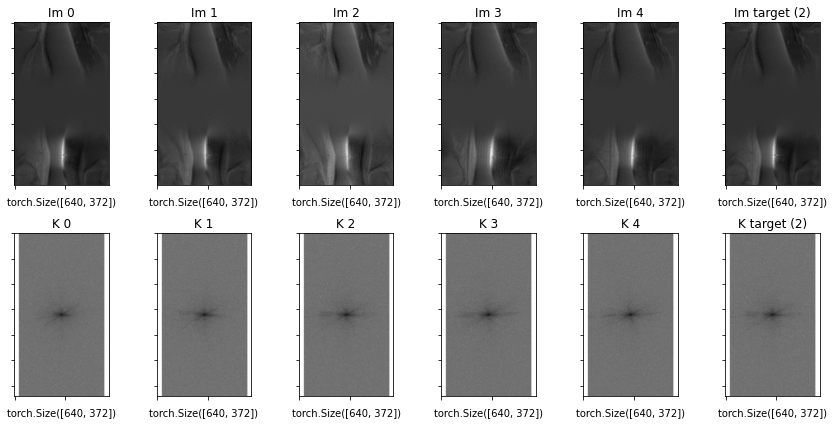

In [65]:
sandw_idx = np.random.randint(sandw_tfm.total_n_sandws)
print(f"Sandwich {sandw_idx}")

fn2attr_items   = sandw_tfm.fn2attr_items
cumsum_n_sandws = sandw_tfm.cumsum_n_sandws
n_seq           = sandw_tfm.n_seq

# get file
fn_idx  = np.searchsorted(cumsum_n_sandws, sandw_idx)
fname   = fn2attr_items[fn_idx][0]

# sandwich index within file
sw_idx   = sandw_idx - cumsum_n_sandws[fn_idx]

# get kspace sandwich, target slice + neighbor slices on either side
with h5py.File(fname, 'r') as data:
  ksandw = data['kspace'][sw_idx:sw_idx+ n_seq]      
  target = data['kspace'][sw_idx +  n_seq//2]

ksandw, target = T.to_tensor(ksandw), T.to_tensor(target)
# return ksandw, target

# decodes sandwich
rev_xb = apply(ksandw, TensorTfms.k2real(onesided=False))
print(f"Sandwich kspace2img: tensor of shape {rev_xb.shape}")

# kspace abs sandwich
k_abs_xb = apply(ksandw, TensorTfms.log_abs, pre=TensorTfms.t_abs)
print(f"Sandwich log abs kspace: tensor of shape {k_abs_xb.shape}")

# decodes target
rev_target = apply(target, TensorTfms.k2real(onesided=False))
print(f"Target kspace2img: tensor of shape {rev_target.shape}")

# kspace abs target
k_abs_target = apply(target, TensorTfms.log_abs, pre=TensorTfms.t_abs)
print(f"Target log abs kspace: tensor of shape {k_abs_target.shape}")

# plot input sandwich + target
ims  = [rev_xb[i]       for i in range(n_seq)] + [rev_target]
ims += [k_abs_xb[i] for i in range(n_seq)] + [k_abs_target]

titles  = [f"Im {i}" for i in range(n_seq)] + [f"Im target ({n_seq//2})"]
titles += [f"K {i}"  for i in range(n_seq)] + [f"K target ({n_seq//2})"]

plot(ims, titles, nrows=2, ncols=n_seq+1, figsize=(12,6))


In [0]:
T.to_tensor??

In [6]:
fn2attr_items

(#40) [('/content/drive/My Drive/fastai_proj/fastmri/data/singlecoil_val/file1000631.h5', {'n_slices': 40, 'kspace_shape': [40, 640, 372], 'padding_left': 19, 'padding_right': 354}),('/content/drive/My Drive/fastai_proj/fastmri/data/singlecoil_val/file1000314.h5', {'n_slices': 32, 'kspace_shape': [32, 640, 372], 'padding_left': 19, 'padding_right': 354}),('/content/drive/My Drive/fastai_proj/fastmri/data/singlecoil_val/file1000031.h5', {'n_slices': 40, 'kspace_shape': [40, 640, 372], 'padding_left': 19, 'padding_right': 354}),('/content/drive/My Drive/fastai_proj/fastmri/data/singlecoil_val/file1000480.h5', {'n_slices': 33, 'kspace_shape': [33, 640, 372], 'padding_left': 19, 'padding_right': 354}),('/content/drive/My Drive/fastai_proj/fastmri/data/singlecoil_val/file1000071.h5', {'n_slices': 35, 'kspace_shape': [35, 640, 372], 'padding_left': 19, 'padding_right': 354}),('/content/drive/My Drive/fastai_proj/fastmri/data/singlecoil_val/file1000537.h5', {'n_slices': 35, 'kspace_shape': [3

In [9]:
slice_lens = L(x[1]["n_slices"] for x in fn2attr_items)
slice_lens

(#40) [40,32,40,33,35,35,33,30,30,36...]

# Crappifier

Highres $\to$ Lowres 

(mask some lines in kspace)

# Dataset

1. input: undersampled kspace seq, $X_i = \{x_{i-2}, x_{i-1}, x_i, x_{i+1}, x_{i+2} \}$
2. target: fully sampled middle slice, $T_i$